# Customer Segmentation Analysis
# Dataset: Mall Customer Segmentation Data (Kaggle)
# Objective: Cluster customers based on income and spending patterns

# ============================================================================
# 1. IMPORTS AND SETUP
# ============================================================================

In [323]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans, DBSCAN
from sklearn.metrics import silhouette_score
import warnings
import joblib
warnings.filterwarnings('ignore')

# Set plotting style
plt.style.use('default')
sns.set_palette("husl")

# 2. DATA LOADING AND INITIAL EXPLORATION


In [309]:
def load_and_explore_data(filepath='./data/raw_data/Mall_Customers.csv'):
    """Load dataset and perform initial exploration"""
    print("=== LOADING DATASET ===")
    df = pd.read_csv(filepath)
    
    print(f"Dataset loaded successfully!")
    print(f"Shape: {df.shape}")
    print("\nFirst 5 rows:")
    print(df.head())
    
    print("\n=== DATA QUALITY ASSESSMENT ===")
    print(f"Missing values:\n{df.isnull().sum()}")
    print(f"Duplicate records: {df.duplicated().sum()}")
    print(f"Data types:\n{df.dtypes}")
    
    return df

# Load the dataset
df = load_and_explore_data()

=== LOADING DATASET ===
Dataset loaded successfully!
Shape: (200, 5)

First 5 rows:
   CustomerID  Gender  Age  Annual Income (k$)  Spending Score (1-100)
0           1    Male   19                  15                      39
1           2    Male   21                  15                      81
2           3  Female   20                  16                       6
3           4  Female   23                  16                      77
4           5  Female   31                  17                      40

=== DATA QUALITY ASSESSMENT ===
Missing values:
CustomerID                0
Gender                    0
Age                       0
Annual Income (k$)        0
Spending Score (1-100)    0
dtype: int64
Duplicate records: 0
Data types:
CustomerID                 int64
Gender                    object
Age                        int64
Annual Income (k$)         int64
Spending Score (1-100)     int64
dtype: object


# 3. EXPLORATORY DATA ANALYSIS (EDA)



=== STATISTICAL SUMMARY ===
       CustomerID         Age  Annual Income (k$)  Spending Score (1-100)
count  200.000000  200.000000          200.000000              200.000000
mean   100.500000   38.850000           60.560000               50.200000
std     57.879185   13.969007           26.264721               25.823522
min      1.000000   18.000000           15.000000                1.000000
25%     50.750000   28.750000           41.500000               34.750000
50%    100.500000   36.000000           61.500000               50.000000
75%    150.250000   49.000000           78.000000               73.000000
max    200.000000   70.000000          137.000000               99.000000


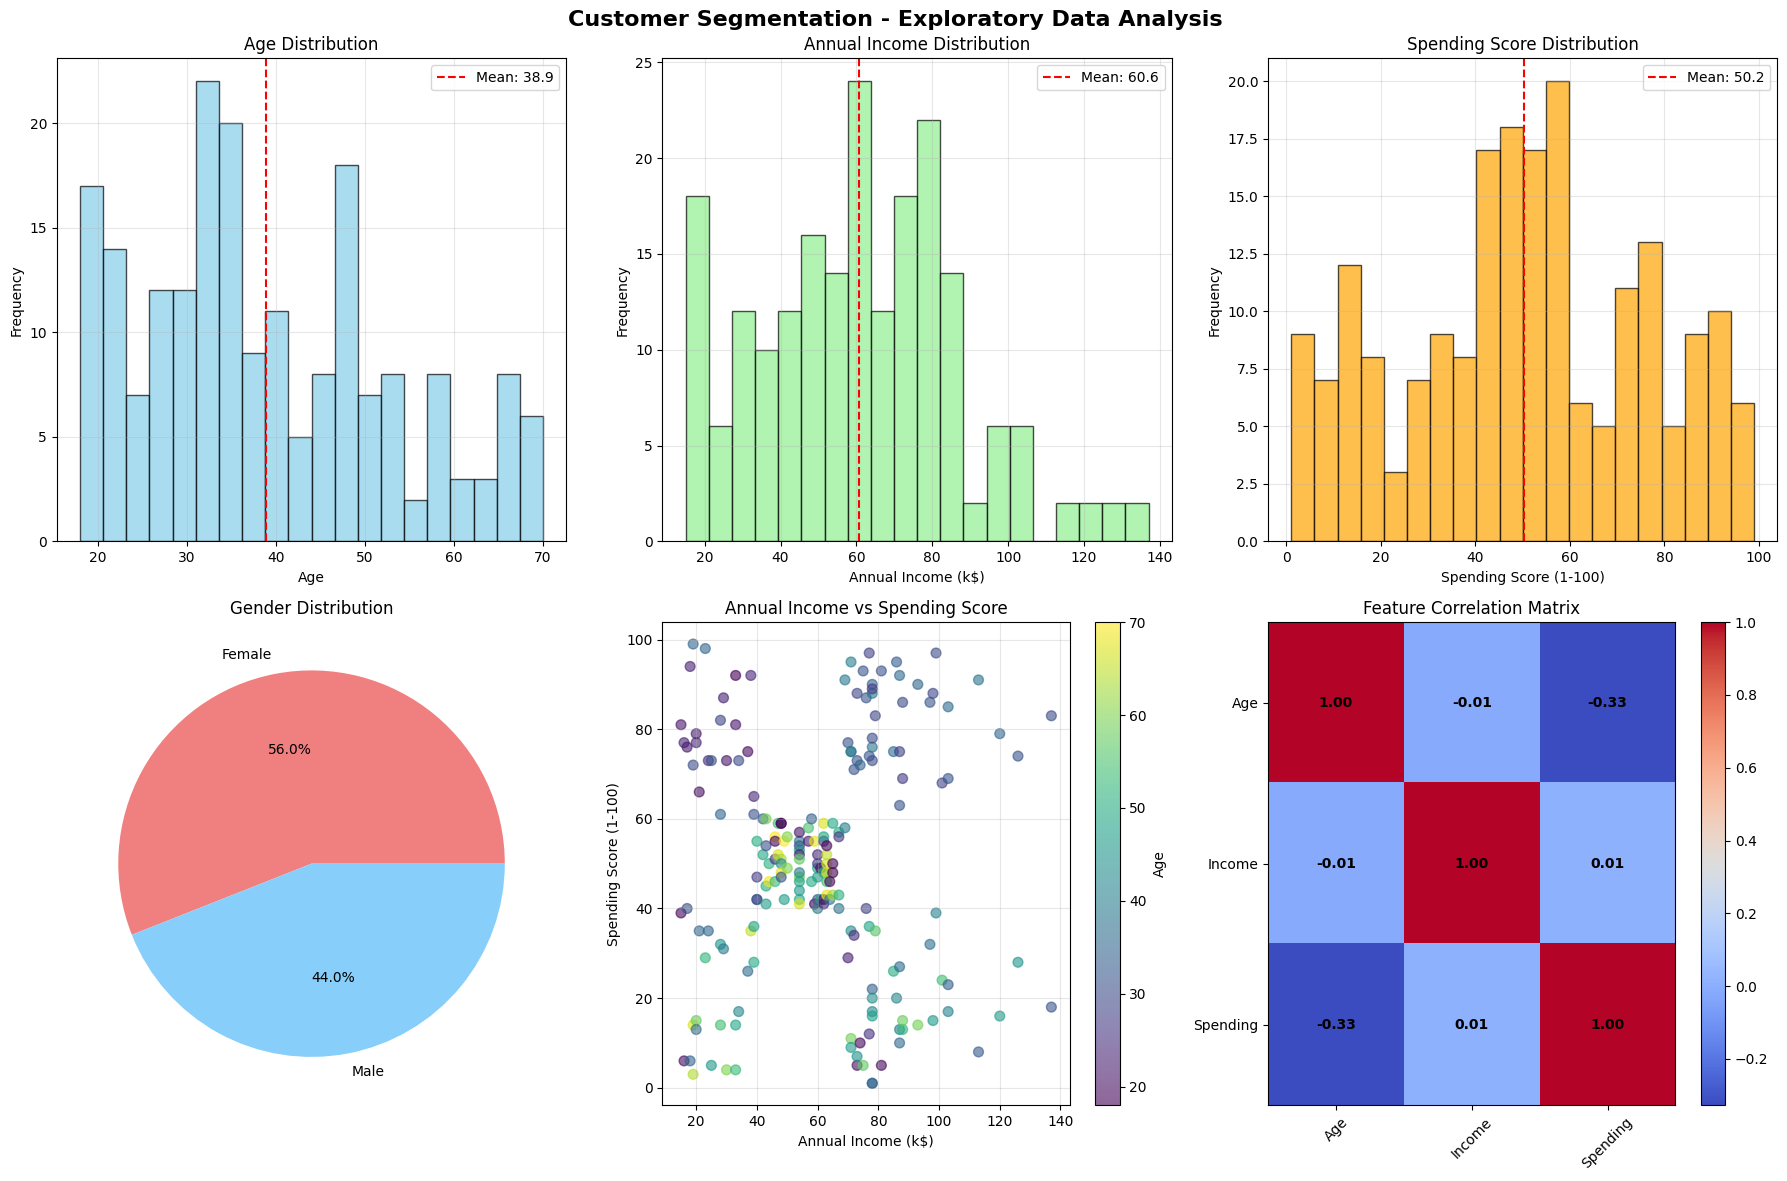

In [312]:
def perform_eda(df):
    """Comprehensive exploratory data analysis"""
    
    print("\n=== STATISTICAL SUMMARY ===")
    print(df.describe())
    
    # Create comprehensive EDA plots
    fig, axes = plt.subplots(2, 3, figsize=(18, 12))
    fig.suptitle('Customer Segmentation - Exploratory Data Analysis', fontsize=16, fontweight='bold')
    
    # Age distribution
    axes[0,0].hist(df['Age'], bins=20, alpha=0.7, color='skyblue', edgecolor='black')
    axes[0,0].set_title('Age Distribution')
    axes[0,0].set_xlabel('Age')
    axes[0,0].set_ylabel('Frequency')
    axes[0,0].axvline(df['Age'].mean(), color='red', linestyle='--', 
                     label=f'Mean: {df["Age"].mean():.1f}')
    axes[0,0].legend()
    axes[0,0].grid(True, alpha=0.3)
    
    # Annual Income distribution
    axes[0,1].hist(df['Annual Income (k$)'], bins=20, alpha=0.7, color='lightgreen', edgecolor='black')
    axes[0,1].set_title('Annual Income Distribution')
    axes[0,1].set_xlabel('Annual Income (k$)')
    axes[0,1].set_ylabel('Frequency')
    axes[0,1].axvline(df['Annual Income (k$)'].mean(), color='red', linestyle='--', 
                     label=f'Mean: {df["Annual Income (k$)"].mean():.1f}')
    axes[0,1].legend()
    axes[0,1].grid(True, alpha=0.3)
    
    # Spending Score distribution
    axes[0,2].hist(df['Spending Score (1-100)'], bins=20, alpha=0.7, color='orange', edgecolor='black')
    axes[0,2].set_title('Spending Score Distribution')
    axes[0,2].set_xlabel('Spending Score (1-100)')
    axes[0,2].set_ylabel('Frequency')
    axes[0,2].axvline(df['Spending Score (1-100)'].mean(), color='red', linestyle='--',
                     label=f'Mean: {df["Spending Score (1-100)"].mean():.1f}')
    axes[0,2].legend()
    axes[0,2].grid(True, alpha=0.3)
    
    # Gender distribution
    gender_counts = df['Gender'].value_counts()
    axes[1,0].pie(gender_counts.values, labels=gender_counts.index, autopct='%1.1f%%', 
                 colors=['lightcoral', 'lightskyblue'])
    axes[1,0].set_title('Gender Distribution')
    
    # Income vs Spending Score scatter plot
    axes[1,1].scatter(df['Annual Income (k$)'], df['Spending Score (1-100)'], 
                     alpha=0.6, c=df['Age'], cmap='viridis', s=50)
    axes[1,1].set_title('Annual Income vs Spending Score')
    axes[1,1].set_xlabel('Annual Income (k$)')
    axes[1,1].set_ylabel('Spending Score (1-100)')
    axes[1,1].grid(True, alpha=0.3)
    cbar = plt.colorbar(axes[1,1].collections[0], ax=axes[1,1])
    cbar.set_label('Age')
    
    # Correlation heatmap
    numeric_cols = ['Age', 'Annual Income (k$)', 'Spending Score (1-100)']
    corr_matrix = df[numeric_cols].corr()
    im = axes[1,2].imshow(corr_matrix, cmap='coolwarm', aspect='auto')
    axes[1,2].set_xticks(range(len(numeric_cols)))
    axes[1,2].set_yticks(range(len(numeric_cols)))
    axes[1,2].set_xticklabels(['Age', 'Income', 'Spending'], rotation=45)
    axes[1,2].set_yticklabels(['Age', 'Income', 'Spending'])
    axes[1,2].set_title('Feature Correlation Matrix')
    
    # Add correlation values to heatmap
    for i in range(len(numeric_cols)):
        for j in range(len(numeric_cols)):
            axes[1,2].text(j, i, f'{corr_matrix.iloc[i, j]:.2f}', 
                          ha='center', va='center', fontweight='bold')
    
    plt.colorbar(im, ax=axes[1,2])
    plt.tight_layout()
    plt.show()

perform_eda(df)

# 4. OUTLIER DETECTION AND ANALYSIS



=== OUTLIER DETECTION ===
CustomerID: 0 outliers (0.0%)
Age: 0 outliers (0.0%)
Annual Income (k$): 2 outliers (1.0%)
Spending Score (1-100): 0 outliers (0.0%)


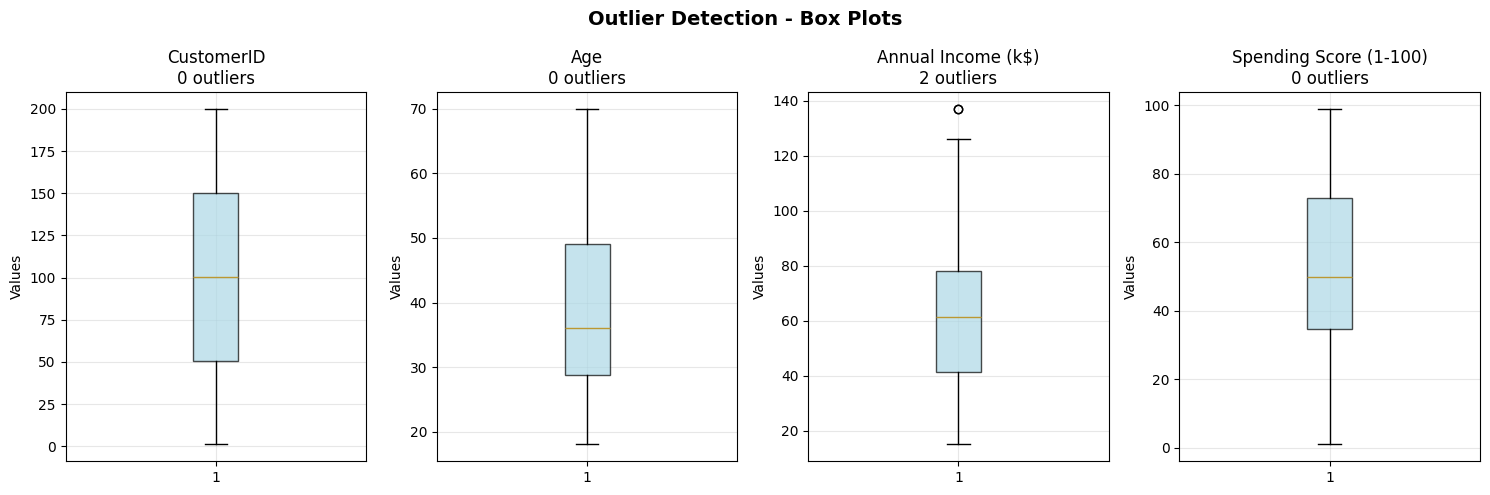

In [322]:
def detect_outliers(df, method='iqr'):
    """Detect outliers using IQR method"""
    print("\n=== OUTLIER DETECTION ===")
    
    def detect_outliers_iqr(data, column):
        Q1 = data[column].quantile(0.25)
        Q3 = data[column].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        outliers = data[(data[column] < lower_bound) | (data[column] > upper_bound)]
        return outliers, lower_bound, upper_bound
    
    numeric_columns = df.select_dtypes(include=[np.number]).columns
    
    # Create outlier visualization
    fig, axes = plt.subplots(1, len(numeric_columns), figsize=(15, 5))
    fig.suptitle('Outlier Detection - Box Plots', fontsize=14, fontweight='bold')
    
    for i, col in enumerate(numeric_columns):
        outliers, lower, upper = detect_outliers_iqr(df, col)
        print(f"{col}: {len(outliers)} outliers ({len(outliers)/len(df)*100:.1f}%)")
        
        # Box plot
        axes[i].boxplot(df[col], patch_artist=True, 
                       boxprops=dict(facecolor='lightblue', alpha=0.7))
        axes[i].set_title(f'{col}\n{len(outliers)} outliers')
        axes[i].set_ylabel('Values')
        axes[i].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    return df  # Keep outliers for this analysis as they may represent valid customer segments

df_clean = detect_outliers(df)

# 5. DATA PREPROCESSING FOR CLUSTERING


In [313]:
def preprocess_data(df):
    """Prepare data for clustering analysis"""
    print("\n=== DATA PREPROCESSING ===")
    
    # Remove non-essential columns for clustering
    df_processed = df.drop(columns=['CustomerID'], errors='ignore')
    print("Removed CustomerID column")
    
    # Focus on numerical features for clustering
    # Using Income and Spending Score as primary features for segmentation
    clustering_features = ['Annual Income (k$)', 'Spending Score (1-100)']
    X = df_processed[clustering_features].values
    
    print(f"Selected features for clustering: {clustering_features}")
    print(f"Data shape for clustering: {X.shape}")
    
    # Feature scaling (StandardScaler)
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    
    print("Applied StandardScaler to features")
    print(f"Original feature ranges:")
    for i, feature in enumerate(clustering_features):
        print(f"  {feature}: [{X[:, i].min():.1f}, {X[:, i].max():.1f}]")
    
    return X, X_scaled, scaler, clustering_features

X, X_scaled, scaler, feature_names = preprocess_data(df_clean)


=== DATA PREPROCESSING ===
Removed CustomerID column
Selected features for clustering: ['Annual Income (k$)', 'Spending Score (1-100)']
Data shape for clustering: (200, 2)
Applied StandardScaler to features
Original feature ranges:
  Annual Income (k$): [15.0, 137.0]
  Spending Score (1-100): [1.0, 99.0]


# 6. OPTIMAL CLUSTER DETERMINATION



=== DETERMINING OPTIMAL NUMBER OF CLUSTERS ===


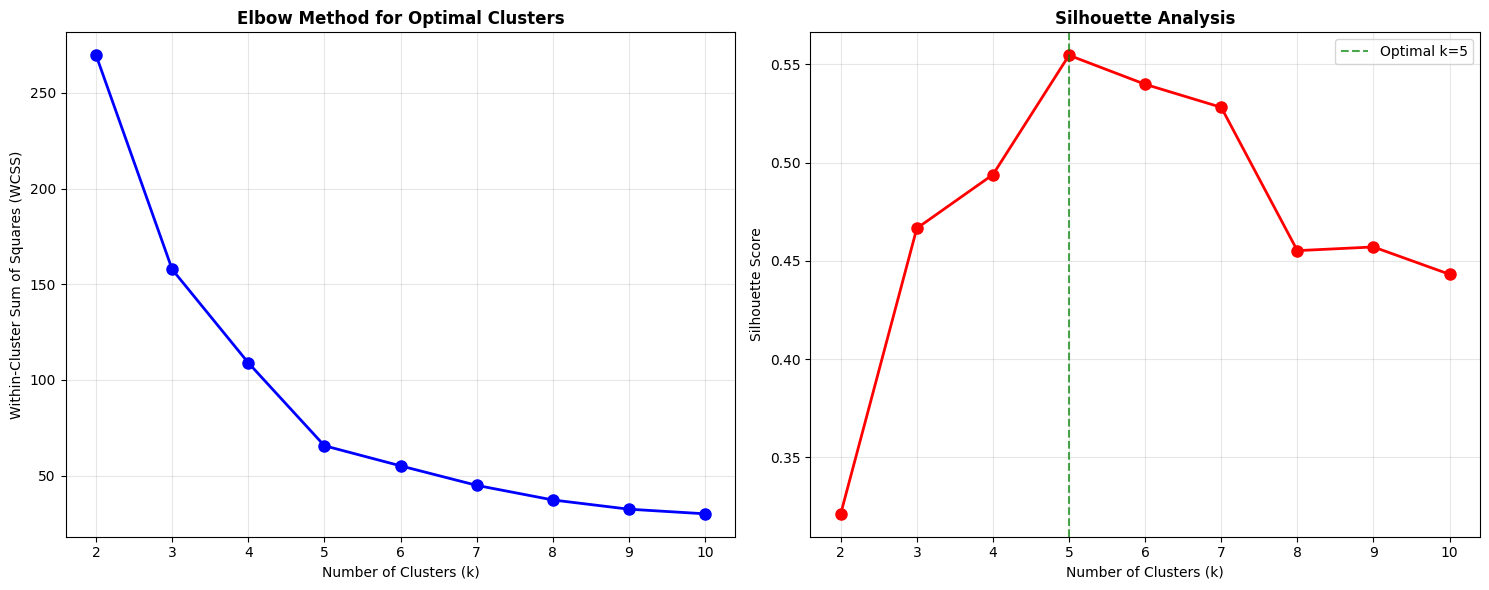

Optimal number of clusters based on Silhouette Score: 5
Silhouette Score for k=5: 0.555


In [315]:
def find_optimal_clusters(X_scaled, max_clusters=10):
    """Use Elbow Method and Silhouette Analysis to find optimal clusters"""
    print("\n=== DETERMINING OPTIMAL NUMBER OF CLUSTERS ===")
    
    # Calculate metrics for different cluster numbers
    cluster_range = range(2, max_clusters + 1)
    inertias = []
    silhouette_scores = []
    
    for k in cluster_range:
        kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
        kmeans.fit(X_scaled)
        inertias.append(kmeans.inertia_)
        silhouette_scores.append(silhouette_score(X_scaled, kmeans.labels_))
    
    # Create plots for cluster selection
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
    
    # Elbow Method
    ax1.plot(cluster_range, inertias, 'bo-', linewidth=2, markersize=8)
    ax1.set_title('Elbow Method for Optimal Clusters', fontweight='bold')
    ax1.set_xlabel('Number of Clusters (k)')
    ax1.set_ylabel('Within-Cluster Sum of Squares (WCSS)')
    ax1.grid(True, alpha=0.3)
    
    # Silhouette Analysis
    ax2.plot(cluster_range, silhouette_scores, 'ro-', linewidth=2, markersize=8)
    ax2.set_title('Silhouette Analysis', fontweight='bold')
    ax2.set_xlabel('Number of Clusters (k)')
    ax2.set_ylabel('Silhouette Score')
    ax2.grid(True, alpha=0.3)
    
    # Highlight optimal k
    optimal_k = cluster_range[np.argmax(silhouette_scores)]
    ax2.axvline(x=optimal_k, color='green', linestyle='--', alpha=0.7, 
                label=f'Optimal k={optimal_k}')
    ax2.legend()
    
    plt.tight_layout()
    plt.show()
    
    print(f"Optimal number of clusters based on Silhouette Score: {optimal_k}")
    print(f"Silhouette Score for k={optimal_k}: {max(silhouette_scores):.3f}")
    
    return optimal_k

optimal_k = find_optimal_clusters(X_scaled)

# 7. K-MEANS CLUSTERING



=== K-MEANS CLUSTERING (k=5) ===
Silhouette Score: 0.555
Inertia (WCSS): 65.57


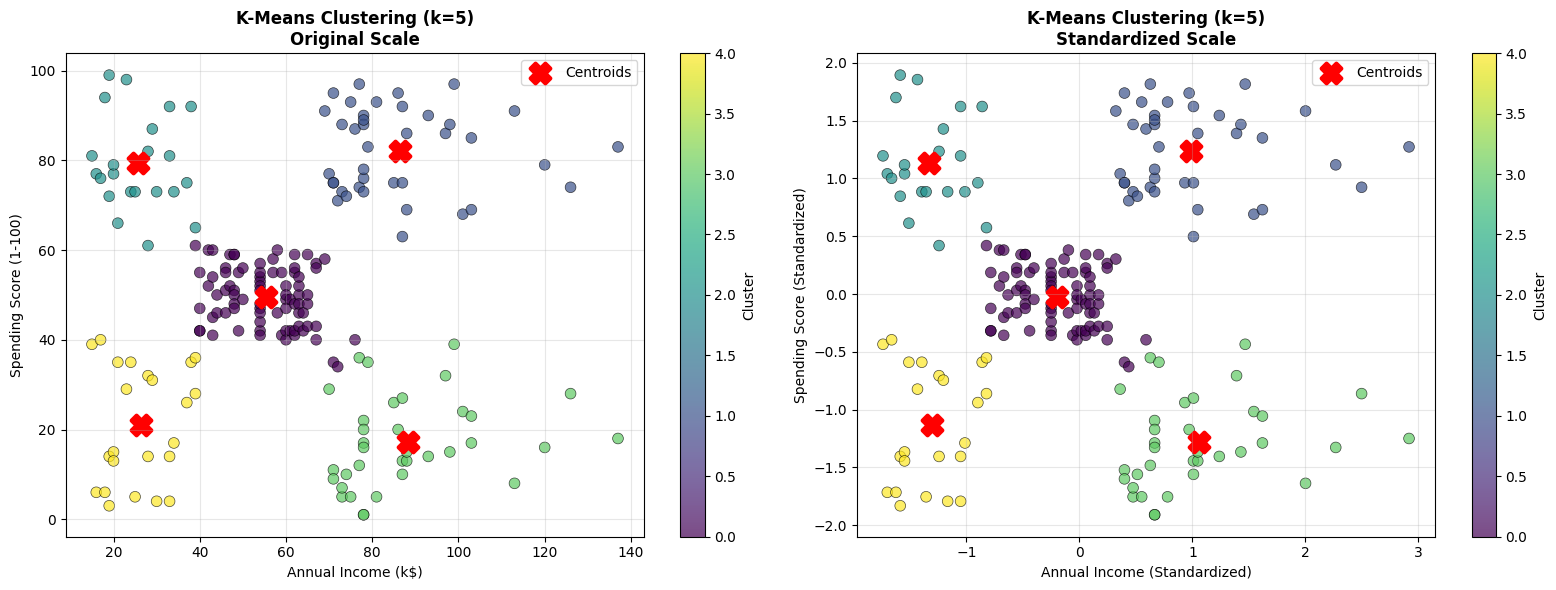

In [316]:
def perform_kmeans_clustering(X, X_scaled, n_clusters=5):
    """Perform K-Means clustering and analyze results"""
    print(f"\n=== K-MEANS CLUSTERING (k={n_clusters}) ===")
    
    # Fit K-Means
    kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
    cluster_labels = kmeans.fit_predict(X_scaled)
    
    # Calculate metrics
    silhouette_avg = silhouette_score(X_scaled, cluster_labels)
    print(f"Silhouette Score: {silhouette_avg:.3f}")
    print(f"Inertia (WCSS): {kmeans.inertia_:.2f}")
    
    # Visualization
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))
    
    # Plot 1: Clusters on original scale
    scatter = ax1.scatter(X[:, 0], X[:, 1], c=cluster_labels, cmap='viridis', 
                         s=60, alpha=0.7, edgecolors='black', linewidth=0.5)
    
    # Transform cluster centers back to original scale
    centers_original = scaler.inverse_transform(kmeans.cluster_centers_)
    ax1.scatter(centers_original[:, 0], centers_original[:, 1], 
               c='red', marker='X', s=200, linewidths=3, label='Centroids')
    
    ax1.set_title(f'K-Means Clustering (k={n_clusters})\nOriginal Scale', fontweight='bold')
    ax1.set_xlabel('Annual Income (k$)')
    ax1.set_ylabel('Spending Score (1-100)')
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    
    # Add colorbar
    cbar1 = plt.colorbar(scatter, ax=ax1)
    cbar1.set_label('Cluster')
    
    # Plot 2: Clusters on scaled data
    scatter2 = ax2.scatter(X_scaled[:, 0], X_scaled[:, 1], c=cluster_labels, 
                          cmap='viridis', s=60, alpha=0.7, edgecolors='black', linewidth=0.5)
    ax2.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1], 
               c='red', marker='X', s=200, linewidths=3, label='Centroids')
    
    ax2.set_title(f'K-Means Clustering (k={n_clusters})\nStandardized Scale', fontweight='bold')
    ax2.set_xlabel('Annual Income (Standardized)')
    ax2.set_ylabel('Spending Score (Standardized)')
    ax2.legend()
    ax2.grid(True, alpha=0.3)
    
    # Add colorbar
    cbar2 = plt.colorbar(scatter2, ax=ax2)
    cbar2.set_label('Cluster')
    
    plt.tight_layout()
    plt.show()
    
    return kmeans, cluster_labels

kmeans_model, kmeans_labels = perform_kmeans_clustering(X, X_scaled, optimal_k)

# 8. CLUSTER ANALYSIS AND INTERPRETATION



=== CLUSTER ANALYSIS ===
Cluster Statistics:
           Age              Annual Income (k$)        Spending Score (1-100)  \
          mean    std count               mean    std                   mean   
Cluster                                                                        
0        42.72  16.45    81              55.30   8.99                  49.52   
1        32.69   3.73    39              86.54  16.31                  82.13   
2        25.27   5.26    22              25.73   7.57                  79.36   
3        41.11  11.34    35              88.20  16.40                  17.11   
4        45.22  13.23    23              26.30   7.89                  20.91   

                
           std  
Cluster         
0         6.53  
1         9.36  
2        10.50  
3         9.95  
4        13.02  

=== CLUSTER INTERPRETATION ===

Cluster 0 (81 customers, 40.5%):
  Average Income: $55.3k
  Average Spending Score: 49.5/100
  Average Age: 42.7 years
  Profile: Budget Custome

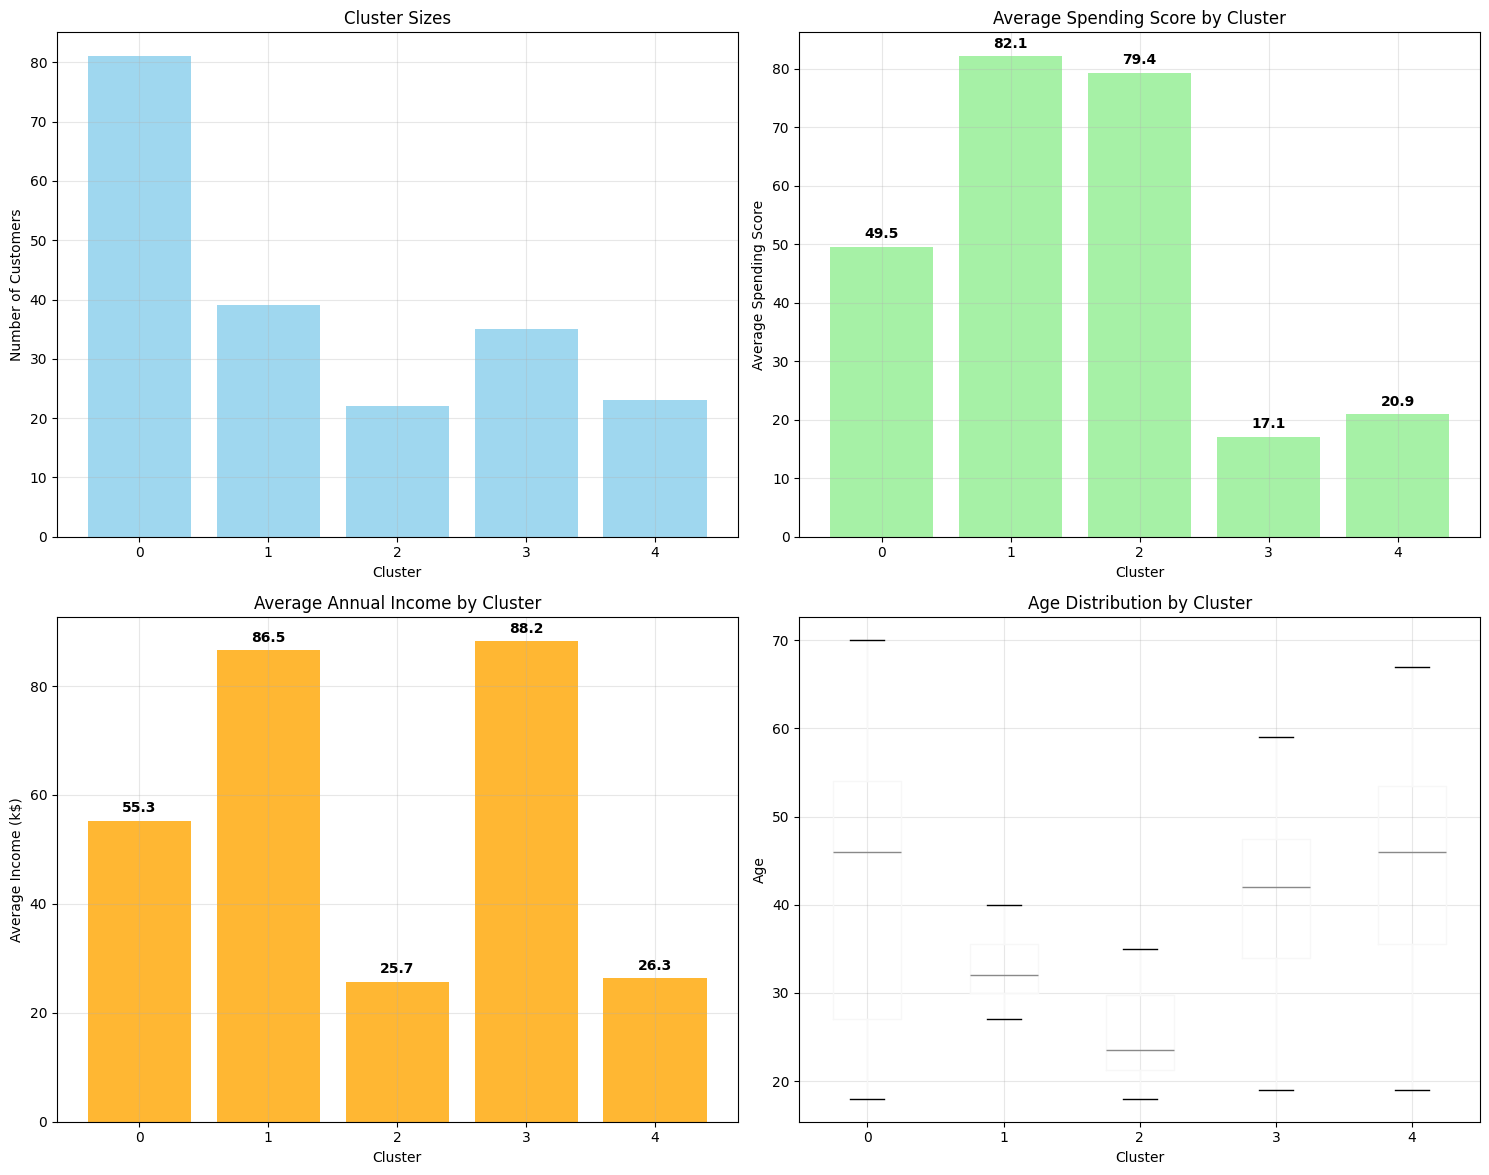

In [317]:
def analyze_clusters(df, cluster_labels, feature_names):
    """Analyze and interpret cluster characteristics"""
    print("\n=== CLUSTER ANALYSIS ===")
    
    # Add cluster labels to dataframe
    df_analysis = df.copy()
    df_analysis['Cluster'] = cluster_labels
    
    # Calculate cluster statistics
    cluster_stats = df_analysis.groupby('Cluster').agg({
        'Age': ['mean', 'std', 'count'],
        'Annual Income (k$)': ['mean', 'std'],
        'Spending Score (1-100)': ['mean', 'std']
    }).round(2)
    
    print("Cluster Statistics:")
    print(cluster_stats)
    
    # Cluster interpretation
    print("\n=== CLUSTER INTERPRETATION ===")
    cluster_profiles = df_analysis.groupby('Cluster')[feature_names + ['Age']].mean()
    
    for cluster_id in range(len(cluster_profiles)):
        income = cluster_profiles.loc[cluster_id, 'Annual Income (k$)']
        spending = cluster_profiles.loc[cluster_id, 'Spending Score (1-100)']
        age = cluster_profiles.loc[cluster_id, 'Age']
        count = len(df_analysis[df_analysis['Cluster'] == cluster_id])
        
        print(f"\nCluster {cluster_id} ({count} customers, {count/len(df_analysis)*100:.1f}%):")
        print(f"  Average Income: ${income:.1f}k")
        print(f"  Average Spending Score: {spending:.1f}/100")
        print(f"  Average Age: {age:.1f} years")
        
        # Business interpretation
        if income >= 60 and spending >= 60:
            profile = "High Value Customers (High Income, High Spending)"
        elif income >= 60 and spending < 60:
            profile = "Potential Customers (High Income, Low Spending)"
        elif income < 60 and spending >= 60:
            profile = "Loyal Customers (Low Income, High Spending)"
        else:
            profile = "Budget Customers (Low Income, Low Spending)"
        
        print(f"  Profile: {profile}")
    
    # Visualization of cluster characteristics
    fig, axes = plt.subplots(2, 2, figsize=(15, 12))
    fig.suptitle('Cluster Analysis - Customer Segments', fontsize=16, fontweight='bold')
    
    # Cluster size
    cluster_counts = df_analysis['Cluster'].value_counts().sort_index()
    axes[0,0].bar(cluster_counts.index, cluster_counts.values, color='skyblue', alpha=0.8)
    axes[0,0].set_title('Cluster Sizes')
    axes[0,0].set_xlabel('Cluster')
    axes[0,0].set_ylabel('Number of Customers')
    axes[0,0].grid(True, alpha=0.3)
    
    # Average spending by cluster
    avg_spending = df_analysis.groupby('Cluster')['Spending Score (1-100)'].mean()
    bars = axes[0,1].bar(avg_spending.index, avg_spending.values, color='lightgreen', alpha=0.8)
    axes[0,1].set_title('Average Spending Score by Cluster')
    axes[0,1].set_xlabel('Cluster')
    axes[0,1].set_ylabel('Average Spending Score')
    axes[0,1].grid(True, alpha=0.3)
    
    # Add value labels on bars
    for bar, value in zip(bars, avg_spending.values):
        axes[0,1].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 1, 
                      f'{value:.1f}', ha='center', va='bottom', fontweight='bold')
    
    # Average income by cluster
    avg_income = df_analysis.groupby('Cluster')['Annual Income (k$)'].mean()
    bars = axes[1,0].bar(avg_income.index, avg_income.values, color='orange', alpha=0.8)
    axes[1,0].set_title('Average Annual Income by Cluster')
    axes[1,0].set_xlabel('Cluster')
    axes[1,0].set_ylabel('Average Income (k$)')
    axes[1,0].grid(True, alpha=0.3)
    
    # Add value labels on bars
    for bar, value in zip(bars, avg_income.values):
        axes[1,0].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 1, 
                      f'{value:.1f}', ha='center', va='bottom', fontweight='bold')
    
    # Age distribution by cluster
    df_analysis.boxplot(column='Age', by='Cluster', ax=axes[1,1])
    axes[1,1].set_title('Age Distribution by Cluster')
    axes[1,1].set_xlabel('Cluster')
    axes[1,1].set_ylabel('Age')
    axes[1,1].grid(True, alpha=0.3)
    
    plt.suptitle('')  # Remove automatic title from boxplot
    plt.tight_layout()
    plt.show()
    
    return df_analysis

df_with_clusters = analyze_clusters(df_clean, kmeans_labels, feature_names)

# 9. ALTERNATIVE CLUSTERING: DBSCAN



=== DBSCAN CLUSTERING (eps=0.5, min_samples=5) ===
Number of clusters: 2
Number of noise points: 8
Silhouette Score (excluding noise): 0.388


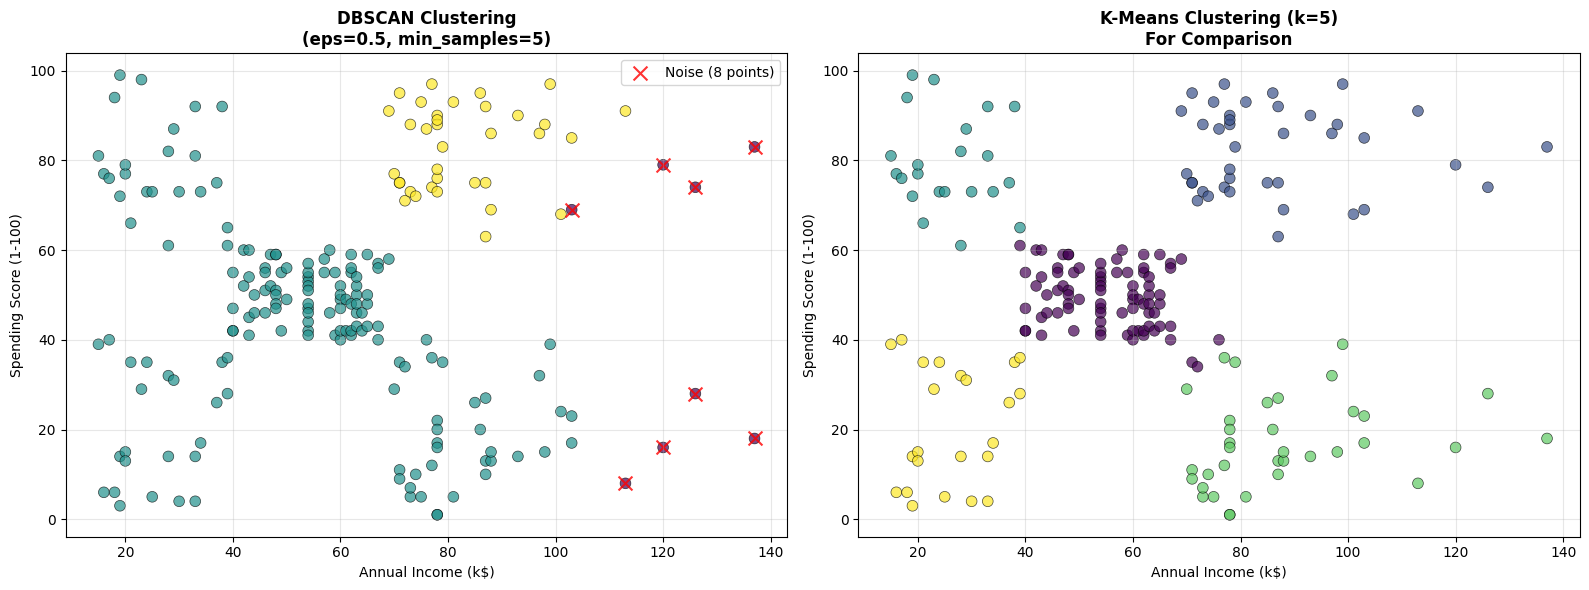

In [318]:
def perform_dbscan_clustering(X_scaled, eps=0.5, min_samples=5):
    """Perform DBSCAN clustering as an alternative method"""
    print(f"\n=== DBSCAN CLUSTERING (eps={eps}, min_samples={min_samples}) ===")
    
    # Fit DBSCAN
    dbscan = DBSCAN(eps=eps, min_samples=min_samples)
    dbscan_labels = dbscan.fit_predict(X_scaled)
    
    # Calculate metrics
    n_clusters = len(set(dbscan_labels)) - (1 if -1 in dbscan_labels else 0)
    n_noise = list(dbscan_labels).count(-1)
    
    print(f"Number of clusters: {n_clusters}")
    print(f"Number of noise points: {n_noise}")
    
    if n_clusters > 1:
        # Calculate silhouette score (excluding noise points)
        if n_noise > 0:
            mask = dbscan_labels != -1
            if np.sum(mask) > 1 and len(set(dbscan_labels[mask])) > 1:
                silhouette_avg = silhouette_score(X_scaled[mask], dbscan_labels[mask])
                print(f"Silhouette Score (excluding noise): {silhouette_avg:.3f}")
        else:
            silhouette_avg = silhouette_score(X_scaled, dbscan_labels)
            print(f"Silhouette Score: {silhouette_avg:.3f}")
    
    # Visualization
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))
    
    # Plot 1: DBSCAN results
    scatter = ax1.scatter(X[:, 0], X[:, 1], c=dbscan_labels, cmap='viridis', 
                         s=60, alpha=0.7, edgecolors='black', linewidth=0.5)
    ax1.set_title(f'DBSCAN Clustering\n(eps={eps}, min_samples={min_samples})', fontweight='bold')
    ax1.set_xlabel('Annual Income (k$)')
    ax1.set_ylabel('Spending Score (1-100)')
    ax1.grid(True, alpha=0.3)
    
    if n_noise > 0:
        # Highlight noise points
        noise_mask = dbscan_labels == -1
        ax1.scatter(X[noise_mask, 0], X[noise_mask, 1], c='red', marker='x', 
                   s=100, alpha=0.8, label=f'Noise ({n_noise} points)')
        ax1.legend()
    
    # Plot 2: Comparison with K-Means
    ax2.scatter(X[:, 0], X[:, 1], c=kmeans_labels, cmap='viridis', 
               s=60, alpha=0.7, edgecolors='black', linewidth=0.5)
    ax2.set_title(f'K-Means Clustering (k={optimal_k})\nFor Comparison', fontweight='bold')
    ax2.set_xlabel('Annual Income (k$)')
    ax2.set_ylabel('Spending Score (1-100)')
    ax2.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    return dbscan, dbscan_labels

# Try DBSCAN with different parameters
dbscan_model, dbscan_labels = perform_dbscan_clustering(X_scaled, eps=0.5, min_samples=5)

# 10. SAVE THE TRAINED MODELS


In [328]:
import os

def save_model_and_results(model, df, scaler, model_type='kmeans', filename='customer_segmentation_results.csv'):
    """
    Save model, scaler, and results for both KMeans and DBSCAN
    
    Parameters:
    - model: trained clustering model (KMeans or DBSCAN)
    - df: scaled data (numpy array or DataFrame)
    - scaler: fitted scaler object
    - model_type: 'kmeans' or 'dbscan'
    - filename: base filename for results
    """
    # Create directories if they don't exist
    os.makedirs(f'./models/{model_type}/', exist_ok=True)
    
    # Save the model
    if model_type.lower() == 'kmeans':
        model_path = f'./models/{model_type}/customer_segmentation_model_{model.n_clusters}.pkl'
        print(f"K-Means model with {model.n_clusters} clusters")
    else:  # DBSCAN
        model_path = f'./models/{model_type}/customer_segmentation_model_{model_type}.pkl'
        print(f"DBSCAN model with eps={model.eps}, min_samples={model.min_samples}")
    
    joblib.dump(model, model_path)
    print(f"Model saved as '{model_path}'")
    
    # Save the scaler (same scaler can be used for both models)
    scaler_path = f'./models/{model_type}/customer_segmentation_scaler.pkl'
    joblib.dump(scaler, scaler_path)
    print(f"Scaler saved as '{scaler_path}'")

    # Save the results (assuming df is the scaled data)
    results_path = f'./models/{model_type}/customer_segmentation_training.csv'
    
    # If df is a numpy array, convert to DataFrame first
    if isinstance(df, np.ndarray):
        # Use meaningful column names based on your features
        column_names = ['Annual_Income_scaled', 'Spending_Score_scaled']
        df_to_save = pd.DataFrame(df, columns=column_names)
    else:
        df_to_save = df
    
    df_to_save.to_csv(results_path, index=False)
    print(f"Results saved as '{results_path}'")
    print("-" * 50)


In [329]:
# Save K-Means model and results
print("=== SAVING K-MEANS MODEL ===")
save_model_and_results(kmeans_model, X_scaled, scaler, model_type='kmeans')


=== SAVING K-MEANS MODEL ===
K-Means model with 5 clusters
Model saved as './models/kmeans/customer_segmentation_model_5.pkl'
Scaler saved as './models/kmeans/customer_segmentation_scaler.pkl'
Results saved as './models/kmeans/customer_segmentation_training.csv'
--------------------------------------------------


In [330]:

# Save DBSCAN model and results
print("\n=== SAVING DBSCAN MODEL ===")
save_model_and_results(dbscan_model, X_scaled, scaler, model_type='dbscan')


=== SAVING DBSCAN MODEL ===
DBSCAN model with eps=0.5, min_samples=5
Model saved as './models/dbscan/customer_segmentation_model_dbscan.pkl'
Scaler saved as './models/dbscan/customer_segmentation_scaler.pkl'
Results saved as './models/dbscan/customer_segmentation_training.csv'
--------------------------------------------------


# 11. BUSINESS RECOMMENDATIONS


In [319]:
def generate_business_recommendations(df_analysis):
    """Generate actionable business recommendations based on clustering results"""
    print("\n" + "="*60)
    print("BUSINESS RECOMMENDATIONS")
    print("="*60)
    
    cluster_profiles = df_analysis.groupby('Cluster').agg({
        'Annual Income (k$)': 'mean',
        'Spending Score (1-100)': 'mean',
        'Age': 'mean'
    }).round(1)
    
    cluster_sizes = df_analysis['Cluster'].value_counts().sort_index()
    
    for cluster_id in cluster_profiles.index:
        income = cluster_profiles.loc[cluster_id, 'Annual Income (k$)']
        spending = cluster_profiles.loc[cluster_id, 'Spending Score (1-100)']
        age = cluster_profiles.loc[cluster_id, 'Age']
        size = cluster_sizes[cluster_id]
        
        print(f"\nCLUSTER {cluster_id} ({size} customers - {size/len(df_analysis)*100:.1f}%)")
        print(f"Profile: Income ${income}k, Spending {spending}/100, Age {age}")
        
        if income >= 60 and spending >= 60:
            print("🎯 HIGH VALUE CUSTOMERS")
            print("• Maintain premium service and exclusive offers")
            print("• Implement loyalty programs with high-end rewards")
            print("• Focus on retention strategies")
            print("• Upsell premium products and services")
            
        elif income >= 60 and spending < 60:
            print("🔄 POTENTIAL CUSTOMERS")
            print("• Investigate barriers to spending (price sensitivity, product fit)")
            print("• Targeted marketing campaigns highlighting value propositions")
            print("• Personalized recommendations and exclusive previews")
            print("• Consider flexible payment options or bundles")
            
        elif income < 60 and spending >= 60:
            print("💝 LOYAL CUSTOMERS")
            print("• Reward loyalty with special discounts and early access")
            print("• Implement referral programs")
            print("• Focus on affordable product lines")
            print("• Maximize lifetime value through engagement")
            
        else:
            print("💰 BUDGET CUSTOMERS")
            print("• Focus on value-for-money propositions")
            print("• Develop budget-friendly product lines")
            print("• Implement cost-effective marketing channels")
            print("• Consider seasonal promotions and discounts")
    
    print("\n" + "="*60)
    print("OVERALL STRATEGIC RECOMMENDATIONS")
    print("="*60)
    print("1. Segment-specific marketing campaigns")
    print("2. Personalized customer experience based on cluster characteristics")
    print("3. Product development aligned with cluster preferences")
    print("4. Optimized pricing strategies for each segment")
    print("5. Regular cluster analysis to track customer evolution")

generate_business_recommendations(df_with_clusters)


BUSINESS RECOMMENDATIONS

CLUSTER 0 (81 customers - 40.5%)
Profile: Income $55.3k, Spending 49.5/100, Age 42.7
💰 BUDGET CUSTOMERS
• Focus on value-for-money propositions
• Develop budget-friendly product lines
• Implement cost-effective marketing channels
• Consider seasonal promotions and discounts

CLUSTER 1 (39 customers - 19.5%)
Profile: Income $86.5k, Spending 82.1/100, Age 32.7
🎯 HIGH VALUE CUSTOMERS
• Maintain premium service and exclusive offers
• Implement loyalty programs with high-end rewards
• Focus on retention strategies
• Upsell premium products and services

CLUSTER 2 (22 customers - 11.0%)
Profile: Income $25.7k, Spending 79.4/100, Age 25.3
💝 LOYAL CUSTOMERS
• Reward loyalty with special discounts and early access
• Implement referral programs
• Focus on affordable product lines
• Maximize lifetime value through engagement

CLUSTER 3 (35 customers - 17.5%)
Profile: Income $88.2k, Spending 17.1/100, Age 41.1
🔄 POTENTIAL CUSTOMERS
• Investigate barriers to spending (pri

In [320]:
def model_summary():
    """Print comprehensive model summary"""
    print("\n" + "="*60)
    print("MODEL SUMMARY")
    print("="*60)
    print(f"Dataset: Mall Customer Segmentation")
    print(f"Total Customers: {len(df_clean)}")
    print(f"Features Used: {feature_names}")
    print(f"Preprocessing: StandardScaler")
    print(f"Optimal Clusters (K-Means): {optimal_k}")
    print(f"Final Silhouette Score: {silhouette_score(X_scaled, kmeans_labels):.3f}")
    print("="*60)

model_summary()


MODEL SUMMARY
Dataset: Mall Customer Segmentation
Total Customers: 200
Features Used: ['Annual Income (k$)', 'Spending Score (1-100)']
Preprocessing: StandardScaler
Optimal Clusters (K-Means): 5
Final Silhouette Score: 0.555


In [321]:
# Save results (optional)
# df_with_clusters.to_csv('customer_segments.csv', index=False)
# print("Results saved to 'customer_segments.csv'")

print("\n✅ Customer Segmentation Analysis Complete!")
print("The analysis has successfully identified distinct customer segments")
print("that can be used for targeted marketing and business strategies.")


✅ Customer Segmentation Analysis Complete!
The analysis has successfully identified distinct customer segments
that can be used for targeted marketing and business strategies.
